## Determining point groups of wallpaper-symmetric images
Given an image that is already known to be wallpaper-symmetric, this code determines the point group. Within a fundamental domain, there must be a center of rotation. This code takes an area that is at least the size of the fundamental domain, generates random points, and then rotates around each point by 60, 90, 120, and 180 degrees. If rotating around any of those points returns the same (or an extremely similar image), then the corresponding point group is indicated. The key to get this code to work is sampling enough points such that one will be close enough to the true center of rotation.

In [1]:
# Imports
import numpy as np
import math
import time

# For image and video manipulation
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
import glob
from IPython.display import display

# distance stuff
from hausdorff import hausdorff_distance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

# Persistent homology
from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
%matplotlib inline

Given an image, a lens size, and a center point, this function returns a snapshot centered around the point.

In [2]:
def translation_snapshot(img, lens_sz, center):
    (x,y) = upper_left_center(img, center)
    (length, height) = img.size
    
    lens_corner_x = x - lens_sz/2.0 
    lens_corner_y = y - lens_sz/2.0 
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

Given two images, this function returns true if they are "close together." This means it is below the 15th percentile of possible distances between pixel vectors.

In [3]:
def close_dist(img1, img2, low_dist):
    arr1 = np.asarray(img1)
    arr1 = arr1.reshape(-1)
    arr2 = np.asarray(img2)
    arr2 = arr2.reshape(-1)
    # print(math.dist(arr1, arr2))
    if math.dist(arr1, arr2)<low_dist:
        return True
    else:
        return False

Given an image, this function returns the associated vector

In [4]:
def create_arr(image):
    img_arr = np.asarray(image,dtype="uint16")
    img_arr = img_arr.reshape(-1)
    # img_arr = np.insert(img_arr, 0, deg)
    return img_arr

Helper function for find_low_dist() that crawls in the horizontal direction and returns a list of all the image vectors. 

In [5]:
def create_data(img, lens_sz):
    data=[]
    pixels_moved = 0
    while(pixels_moved < lens_sz+2):
        moved_image = translation_snapshot(img, lens_sz, (pixels_moved,0))
        data.append(create_arr(moved_image))
        pixels_moved += 1   
    
    return np.asarray(data)

find_low_dist() samples different euclidean pixel distances between snapshots of the given image and returns the 5th percentile, and so any distance bellow that is considered "close."

In [6]:
def find_low_dist(img, lens_sz):
    data = create_data(img, lens_sz)
    pairwise = pairwise_distances(data)
    q1, q3 = np.percentile(pairwise[0,:], [5, 75])
    return q1

Given a point with the origin in the middle of the image, this function returns the coordinates of the point but with the origin the upper left corner (this is the convention for PIL pillow package functions).

In [7]:
def upper_left_center(img, center):
    (x,y) = center
    (l, h) = img.size
    return (l/2.0+x , h/2.0 - y)    

The following "check" functions take potential center points, rotate around them the degree associated with the symmetry group, and then returns True if any of those rotations return the same image back. For instance, find_C4_centers() rotates 90 degrees about each given point and retuns True if it gets the same (or very similar) image back.

In [8]:
def check_C4(img, lens_sz, x_centers, y_centers, low_dist):
    for i in range(x_centers.size):
        centerT = (x_centers[i], y_centers[i])
        centerU = upper_left_center(img, centerT)
        original = translation_snapshot(img, lens_sz, centerT )
        rotated = translation_snapshot(img.rotate(90, center = centerU), lens_sz, centerT )
        if close_dist(original, rotated, low_dist):
            return True
    return False

In [9]:
def check_C2(img, lens_sz, x_centers, y_centers, low_dist):
    for i in range(x_centers.size):
        centerT = (x_centers[i], y_centers[i])
        centerU = upper_left_center(img, centerT)
        original = translation_snapshot(img, lens_sz, centerT )
        rotated = translation_snapshot(img.rotate(180, center = centerU), lens_sz, centerT )
        if close_dist(original, rotated, low_dist):
            return True
    return False

In [10]:
def check_C6(img, lens_sz, x_centers, y_centers, low_dist):
    for i in range(x_centers.size):
        centerT = (x_centers[i], y_centers[i])
        centerU = upper_left_center(img, centerT)
        original = translation_snapshot(img, lens_sz, centerT )
        rotated = translation_snapshot(img.rotate(60, center = centerU), lens_sz, centerT )
        if close_dist(original, rotated, low_dist):
            return True
    return False

In [11]:
def check_C3(img, lens_sz, x_centers, y_centers, low_dist):
    for i in range(x_centers.size):
        centerT = (x_centers[i], y_centers[i])
        centerU = upper_left_center(img, centerT)
        original = translation_snapshot(img, lens_sz, centerT )
        rotated = translation_snapshot(img.rotate(120, center = centerU), lens_sz, centerT )
        if close_dist(original, rotated, low_dist):
            return True
    return False

find_group() takes an image, a lens size, and n samples. The number of samples is how many points within the lens get checked for rotational symmetry. It first checks if the image is C4 or C6, since check_C3() would say a C6 image is C3 and check_C2() would say a C4 image is C2. If the image is not C2, C3, C4, or C6, the function returns C1 (so find_group() assumes that the given image has translational symmetry).

In [12]:
 def find_group(img, lens_sz, n_samples):
    low_dist = find_low_dist(img, lens_sz)
        
    x_centers = (lens_sz * np.random.random(n_samples) - lens_sz/2.0)
    y_centers = (lens_sz * np.random.random(n_samples) - lens_sz/2.0)
    
    if(check_C4(img, lens_sz, x_centers, y_centers, low_dist)):
        return "C4"
    if(check_C6(img, lens_sz, x_centers, y_centers, low_dist)):
        return "C6"
    if(check_C3(img, lens_sz, x_centers, y_centers, low_dist)):
        return "C3"
    if(check_C2(img, lens_sz, x_centers, y_centers, low_dist)):
        return "C2"
    return "C1"

    

The higher the sample density, the more accurate this method is. When the wrong group is returned, either decrease the lens size or increase the number of samples. The lens can be much larger than the fundamental domain, but then the number of samples must be increased (which dramatically increases the runtime). 

## C4 Test

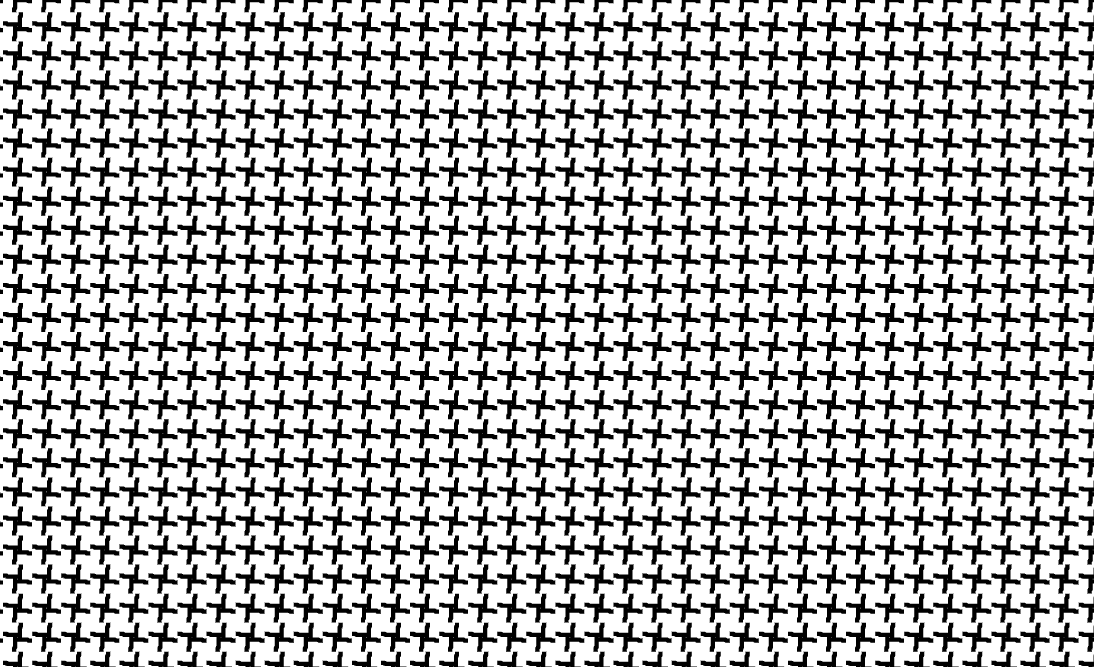

In [101]:
# Grab image from files
img = Image.open('images/C4pinwheel.png')
img = img.convert('L')
display(img)
img.show()

In [14]:
find_group(img, 200, 400)

'C4'

In [104]:
find_group(img, 200, 350)

'C1'

In [42]:
find_group(img, 50, 200)

'C2'

In [41]:
find_group(img, 50, 700)

'C4'

With more samples the code is more accurate.

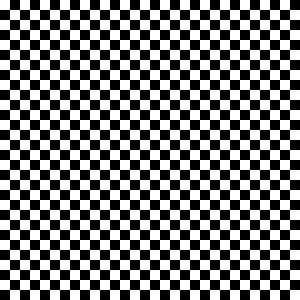

In [48]:
# Grab image from files
img = Image.open('images/smallcheck.jpeg')
img = img.convert('L')
display(img)

In [49]:
find_group(img, 50, 300)

'C4'

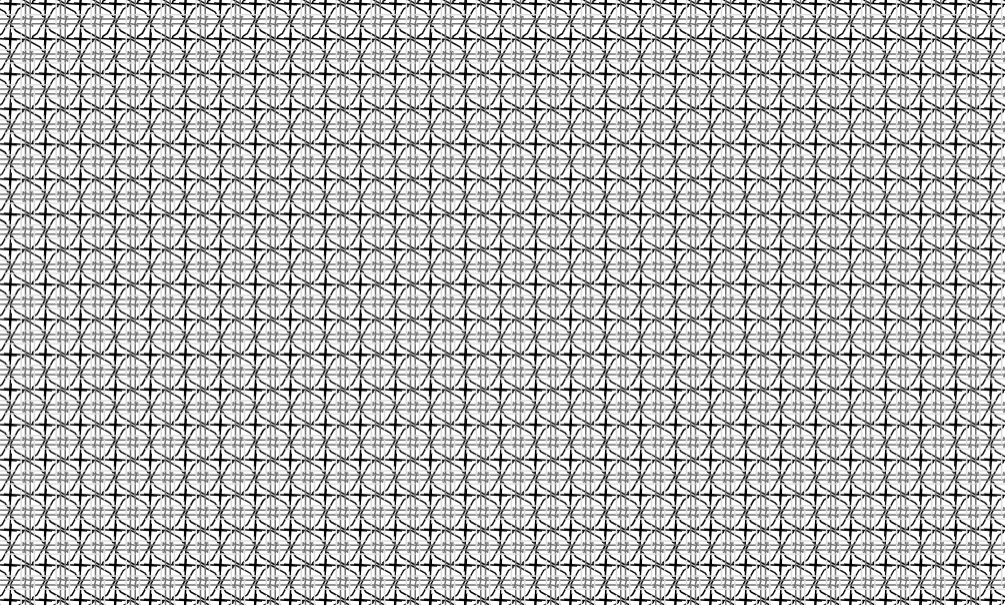

In [51]:
# Grab image from files
img = Image.open('images/C4tiles.png')
img = img.convert('L')
display(img)

In [52]:
find_group(img, 40, 600)

'C4'

## C6 Test

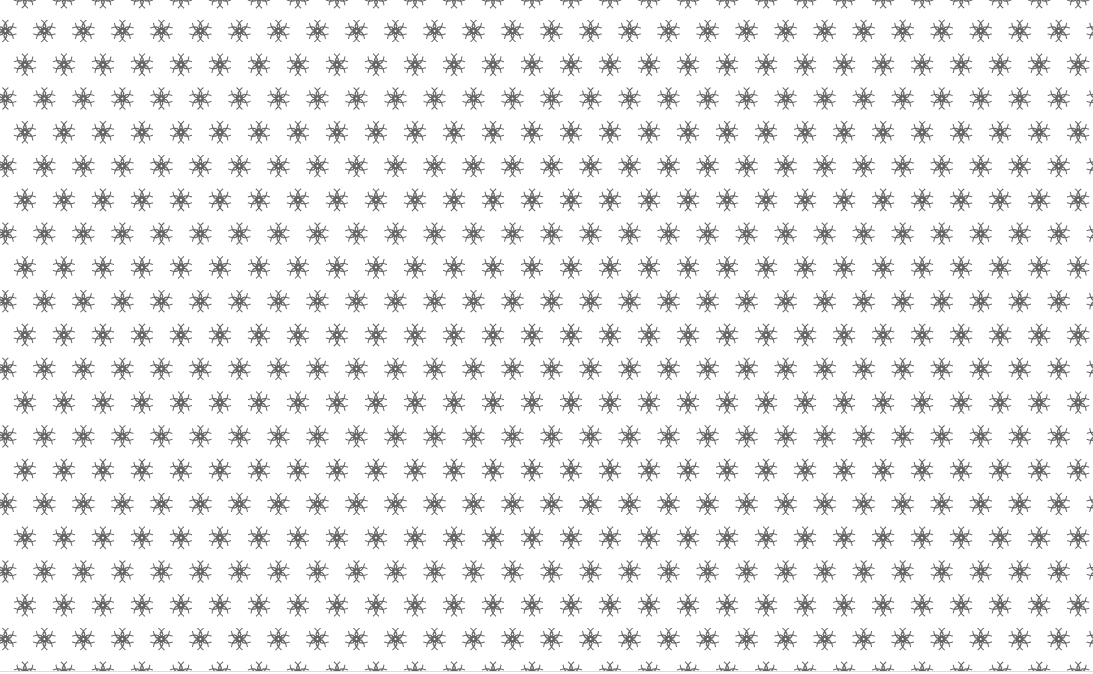

In [55]:
# Grab image from files
img = Image.open('images/C6 snowflake.png')
img = img.convert('L')
display(img)
img.show()

In [57]:
find_group(img, 100, 600)

'C6'

In [58]:
find_group(img, 200, 600)

'C6'

In [105]:
find_group(img, 200, 300)

'C1'

Looks like there were not enough samples in the last case.

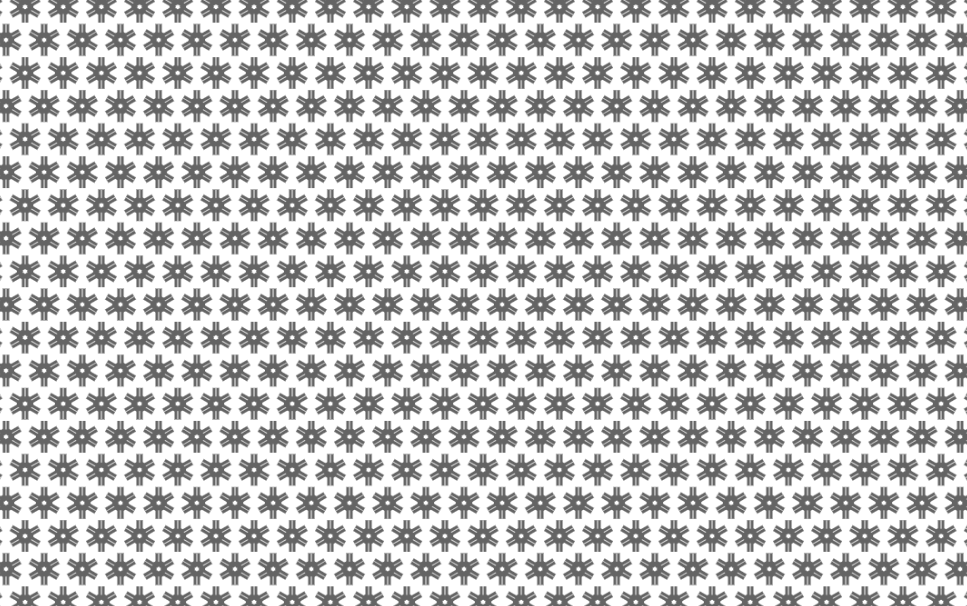

In [61]:
# Grab image from files
img = Image.open('images/C6 star.png')
img = img.convert('L')
display(img)

In [62]:
find_group(img, 200, 600)

'C6'

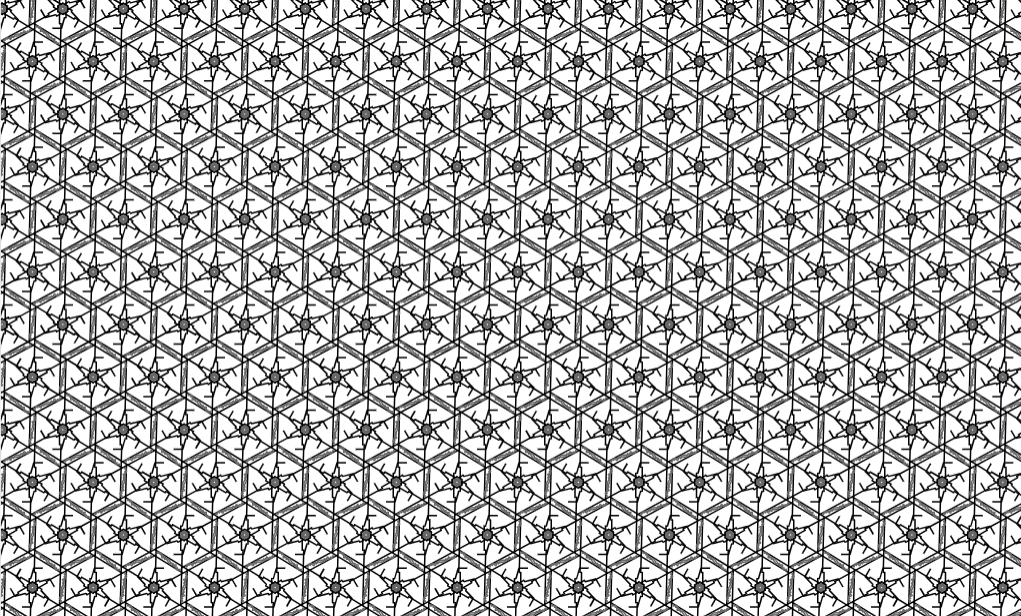

In [63]:
# Grab image from files
img = Image.open('images/C6tiles.png')
img = img.convert('L')
display(img)

In [64]:
find_group(img, 200, 600)

'C6'

## C3 Test

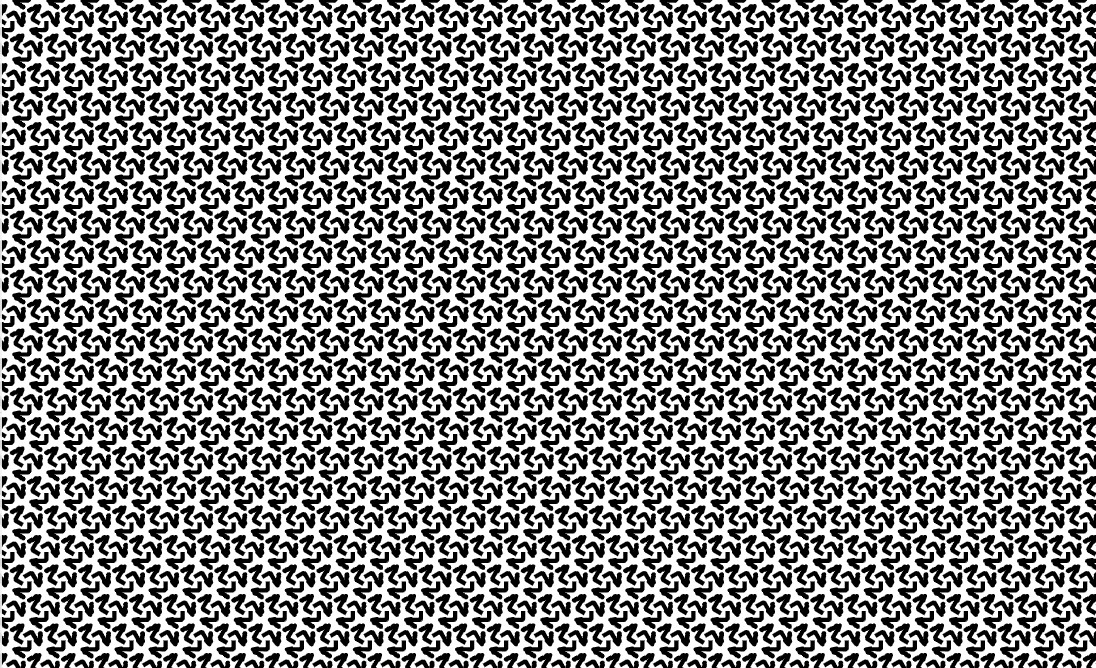

In [65]:
# Grab image from files
img = Image.open('images/C3keith.png')
img = img.convert('L')
display(img)
img.show()

In [66]:
find_group(img, 200, 600)

'C3'

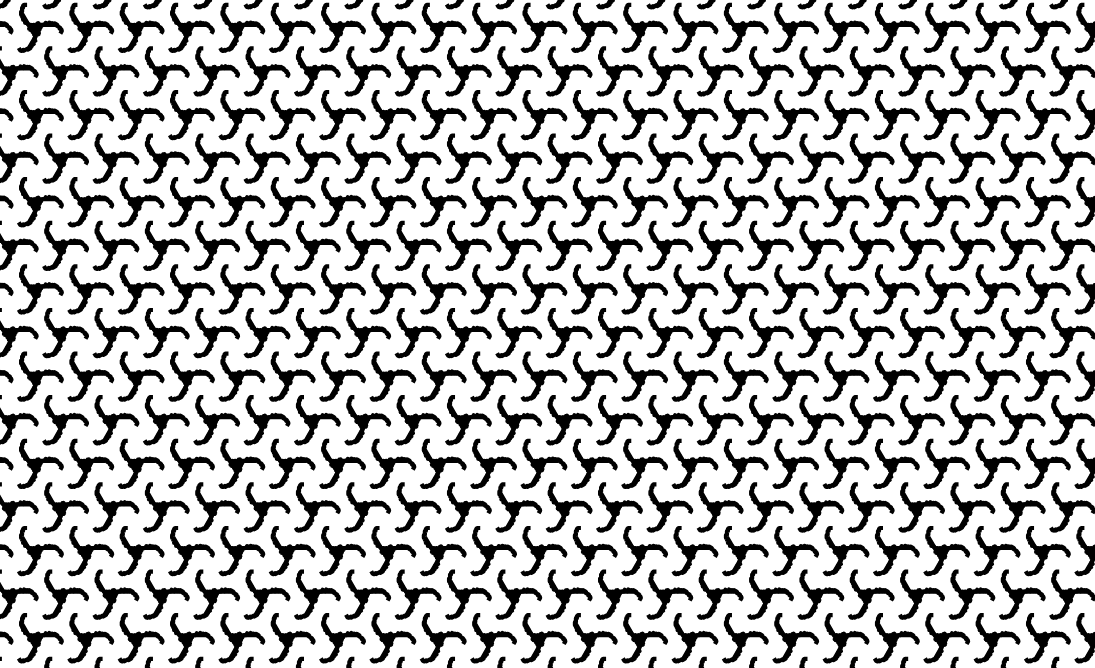

In [67]:
# Grab image from files
img = Image.open('images/C3spiral.png')
img = img.convert('L')
display(img)

In [68]:
find_group(img, 200, 600)

'C3'

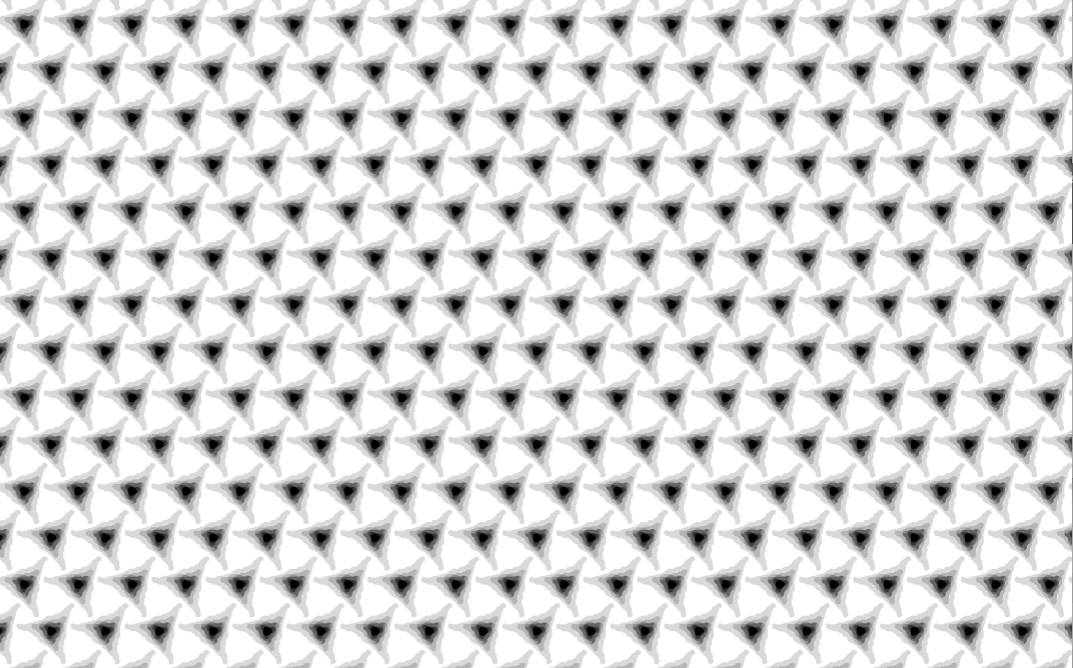

In [69]:
# Grab image from files
img = Image.open('images/C3gradient.png')
img = img.convert('L')
display(img)

In [70]:
find_group(img, 200, 600)

'C3'

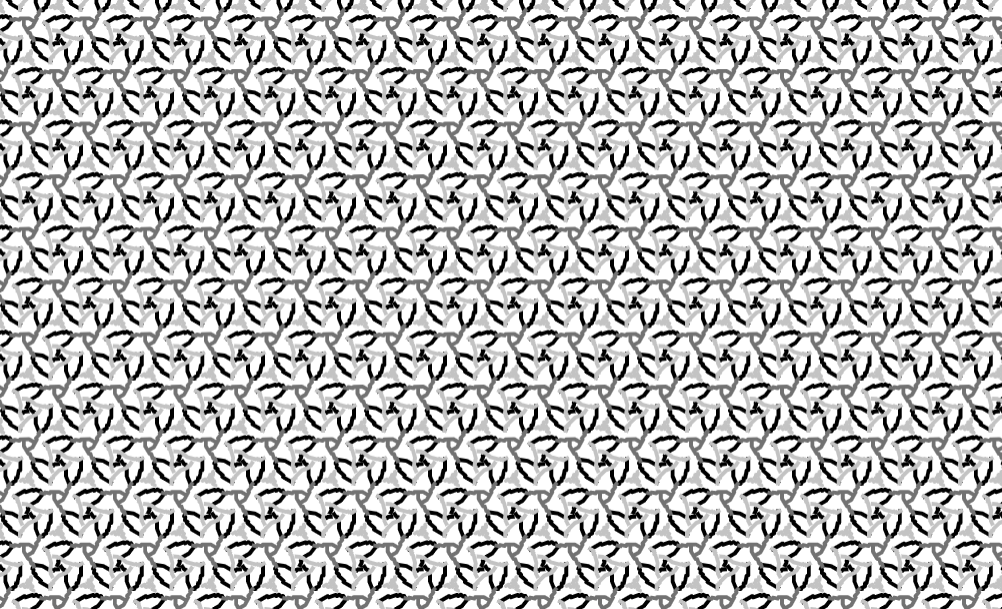

In [72]:
# Grab image from files
img = Image.open('images/C3flowers.png')
img = img.convert('L')
display(img)

In [106]:
find_group(img, 200, 600)

'C1'

In [74]:
find_group(img, 70, 600)

'C3'

If we decrease the lens size it works. It seems like sample density may be important. 

## Test C2

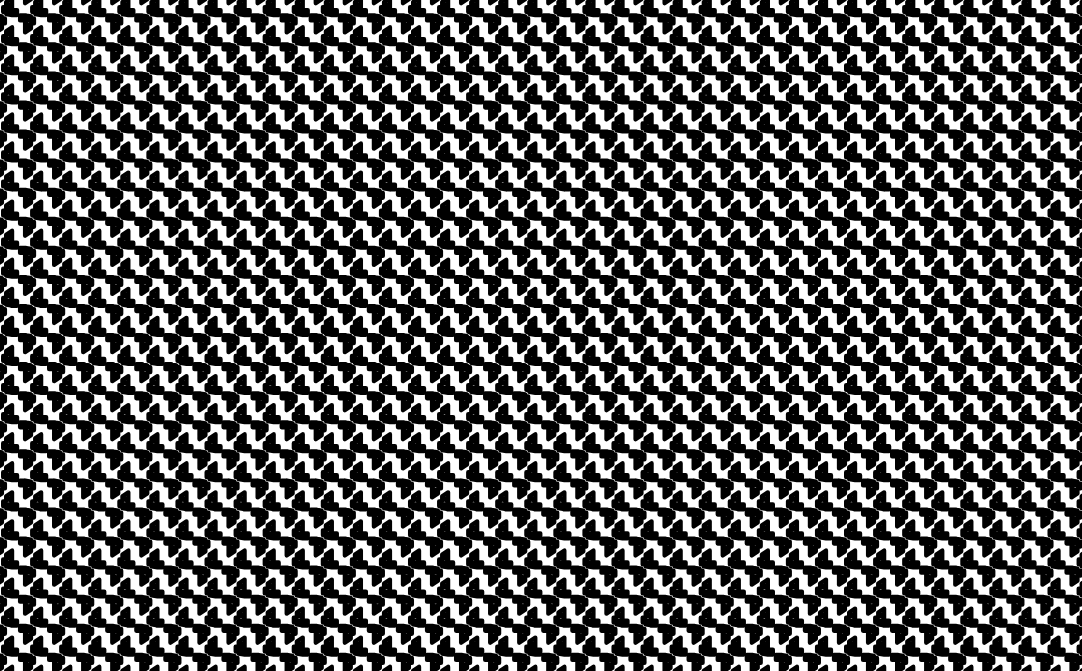

In [78]:
img = Image.open('images/C2bow.png')
img = img.convert('L')
display(img)
img.show()

In [82]:
find_group(img, 200, 600)

'C1'

In [79]:
find_group(img, 50, 800)

'C2'

Again, more samples means more effective.

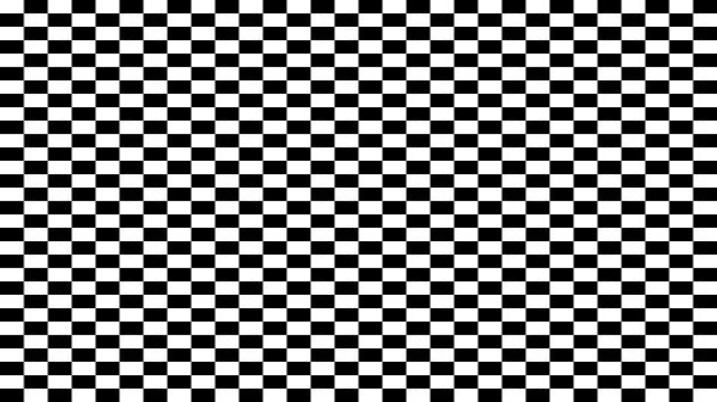

In [80]:
img = Image.open('images/C2checker.jpg')
img = img.convert('L')
display(img)

In [81]:
find_group(img, 200, 600)

'C2'

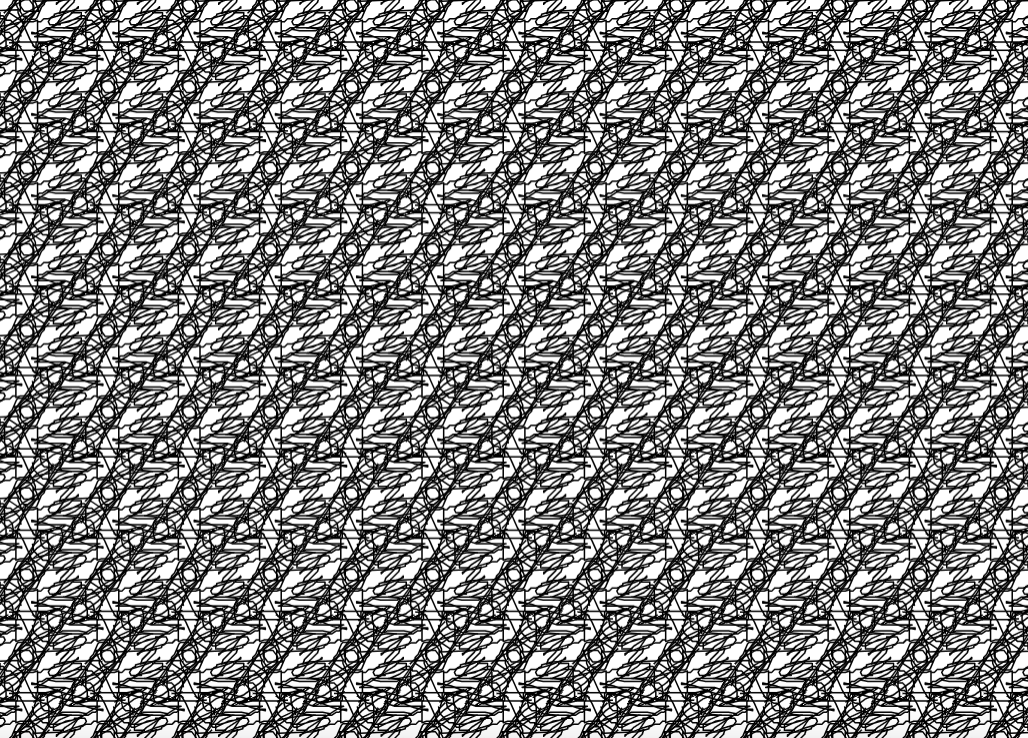

In [83]:
img = Image.open('images/C2scraggle.png')
img = img.convert('L')
display(img)

In [84]:
find_group(img, 200, 600)

'C1'

In [85]:
find_group(img, 200, 800)

'C2'

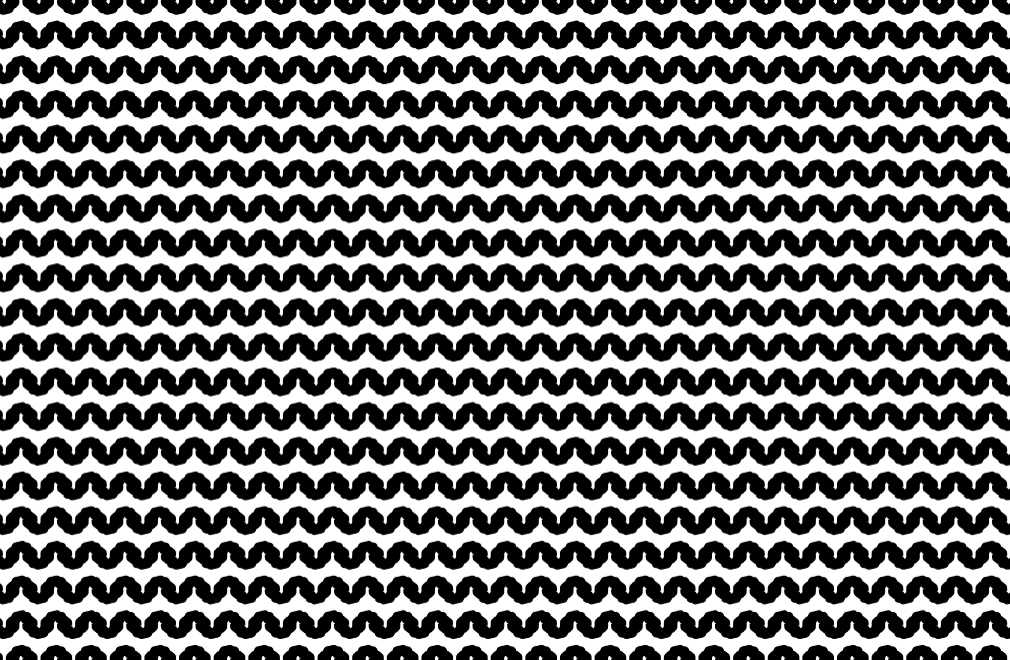

In [86]:
img = Image.open('images/C2sqiggle.png')
img = img.convert('L')
display(img)

In [87]:
find_group(img, 200, 800)

'C2'

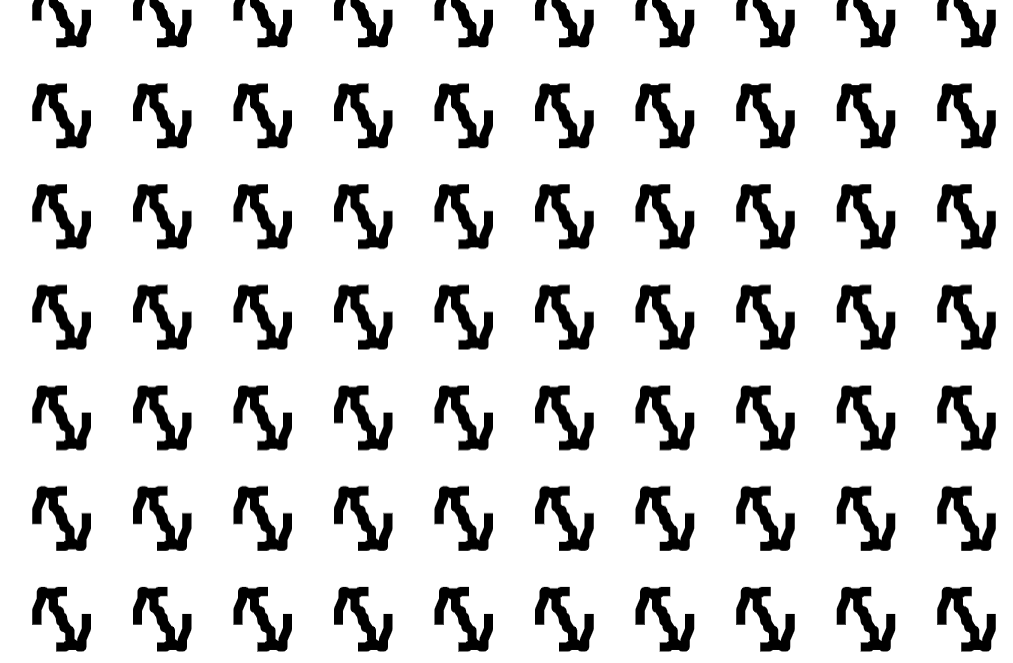

In [88]:
img = Image.open('images/C2bigArrows.png')
img = img.convert('L')
display(img)

In [89]:
find_group(img, 200, 800)

'C2'

## C1 Test

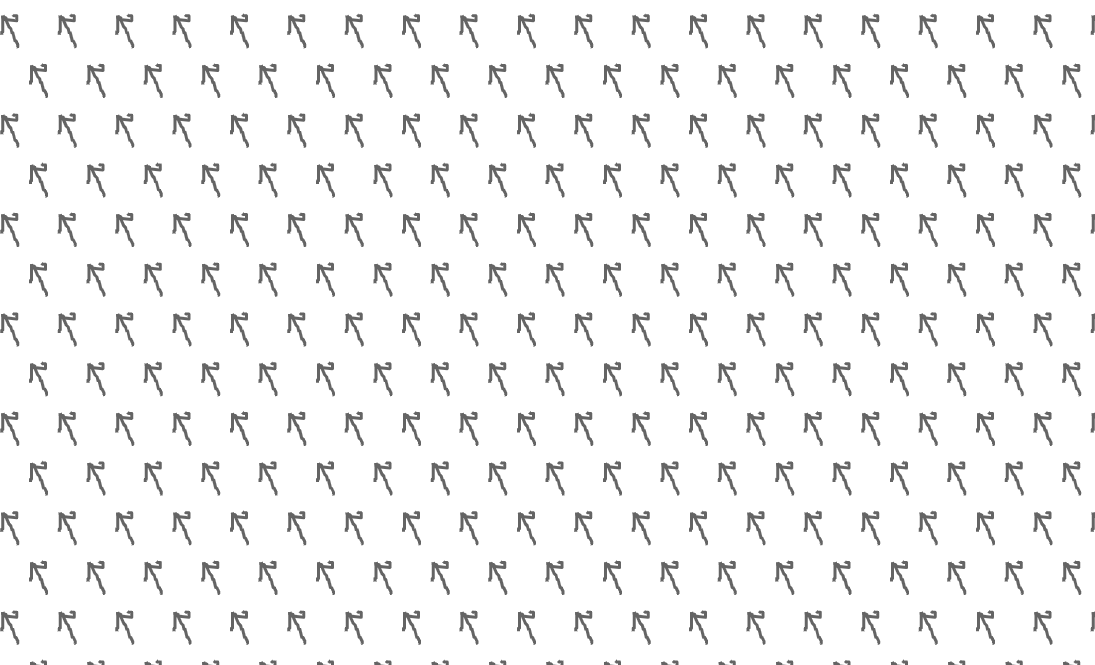

In [90]:
img = Image.open('images/C1 curly arrow.png')
img = img.convert('L')
display(img)

In [91]:
find_group(img, 200, 800)

'C1'

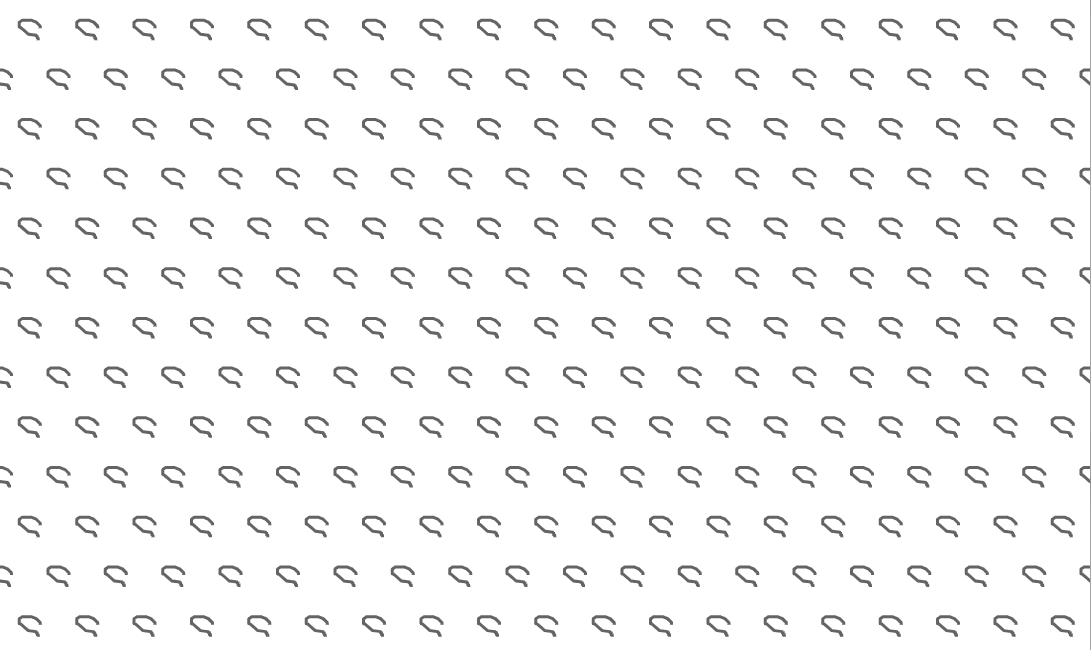

In [92]:
img = Image.open('images/C1 horsehex.png')
img = img.convert('L')
display(img)

In [93]:
find_group(img, 200, 800)

'C1'

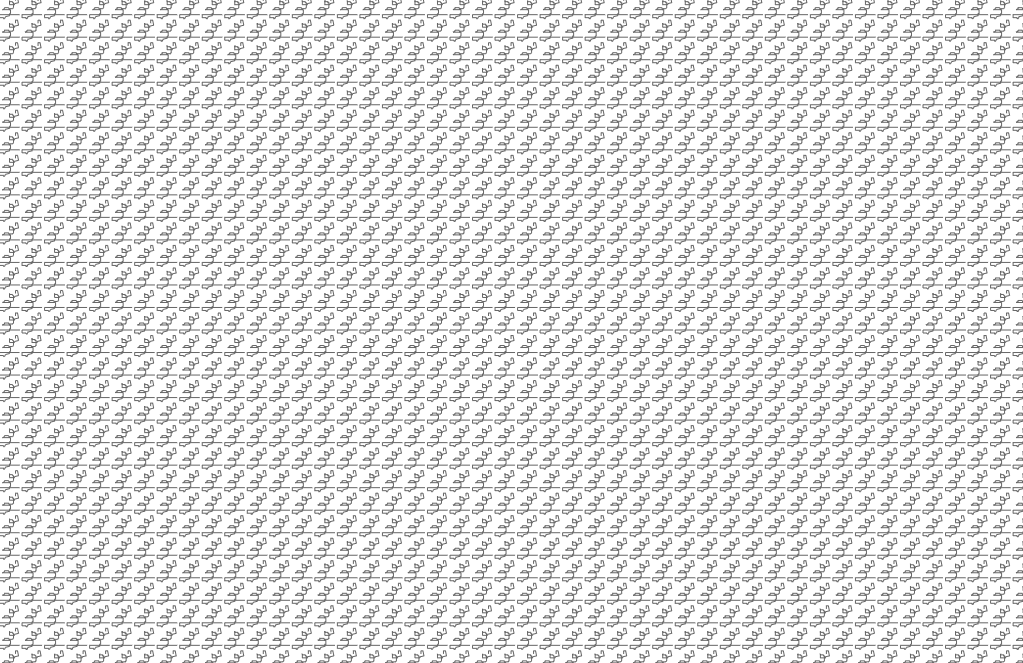

In [94]:
img = Image.open('images/C1 spiral.png')
img = img.convert('L')
display(img)

In [95]:
find_group(img, 50, 800)

'C1'

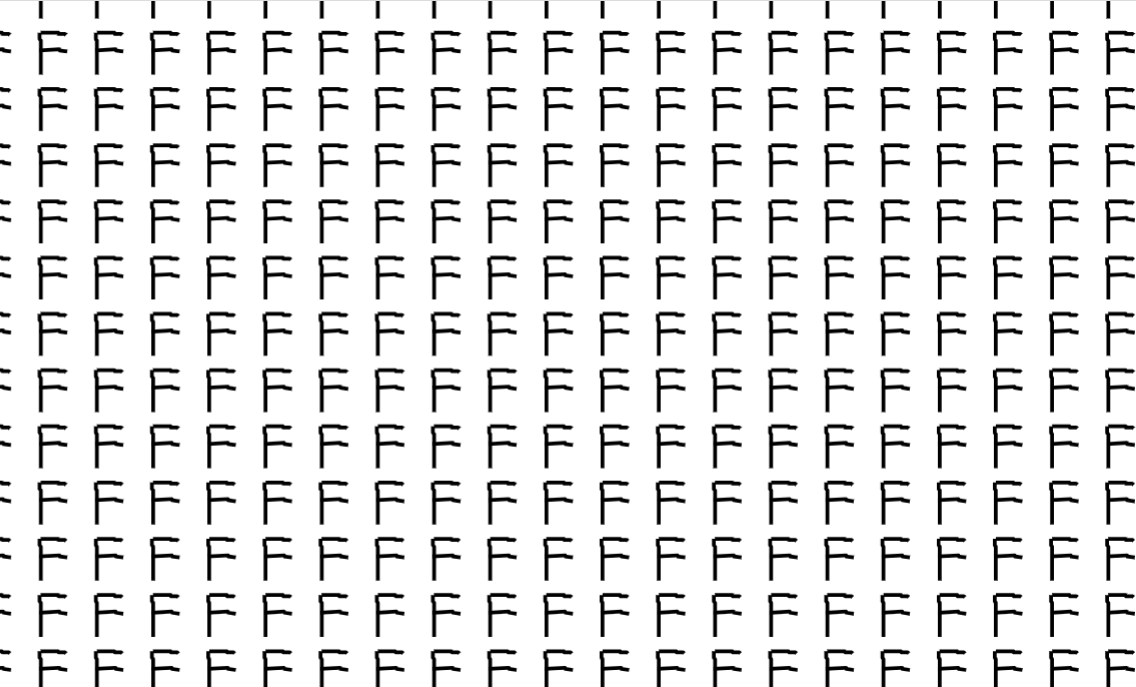

In [44]:
img = Image.open('images/C1_F.png')
img = img.convert('L')
display(img)
img.show()

In [45]:
find_group(img, 60, 600)

'C1'

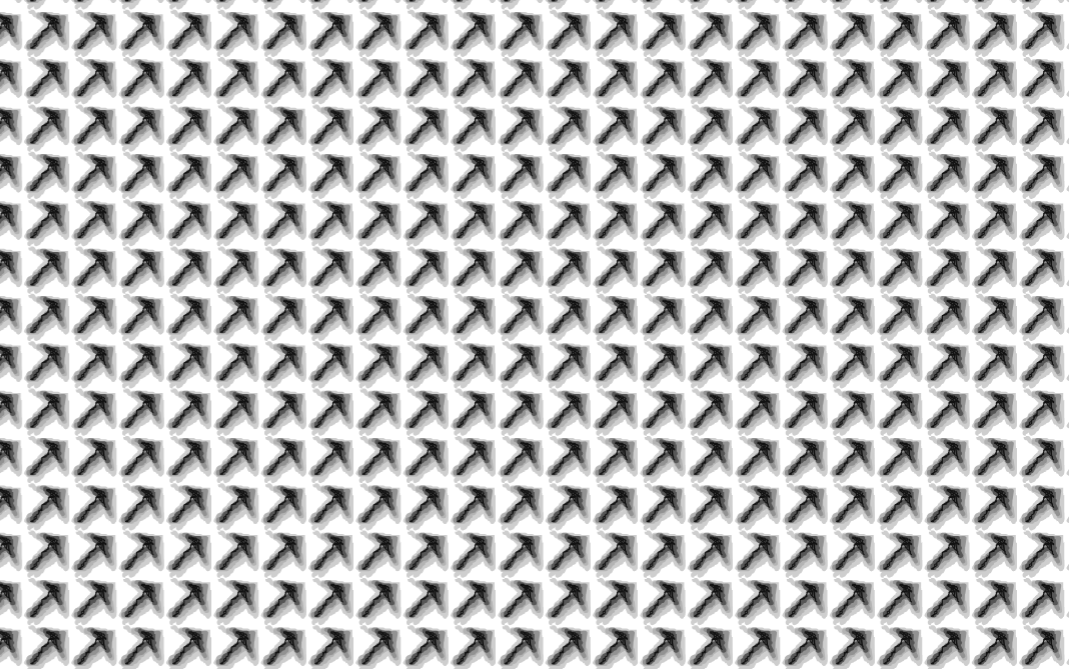

In [96]:
img = Image.open('images/C1gradientArrows.png')
img = img.convert('L')
display(img)

In [97]:
find_group(img, 60, 600)

'C1'

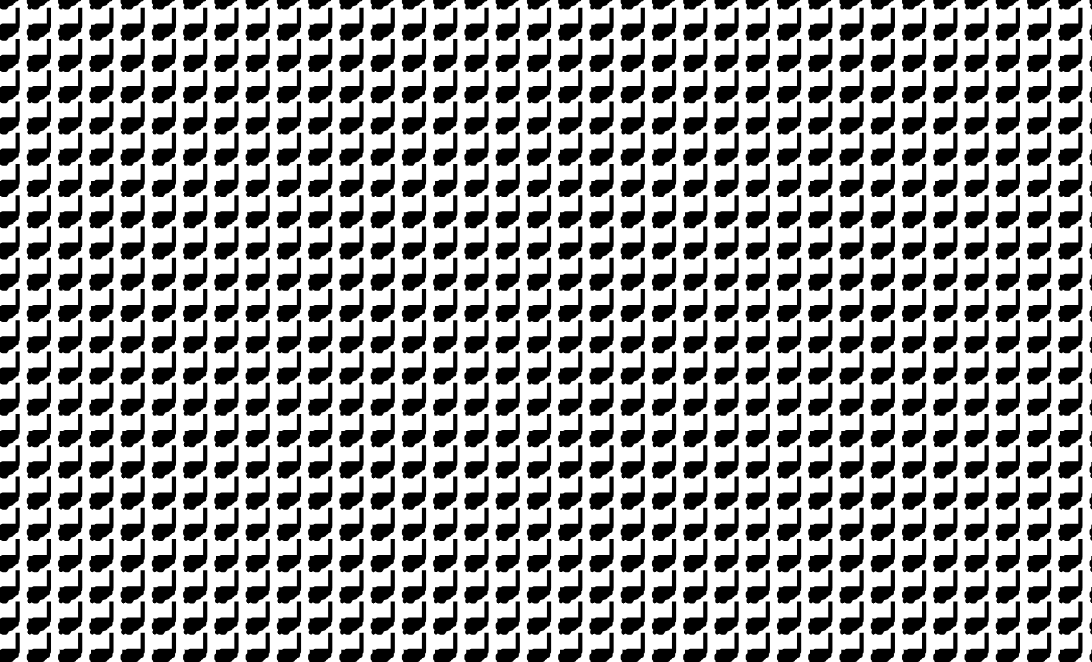

In [98]:
img = Image.open('images/C1music.png')
img = img.convert('L')
display(img)

In [99]:
find_group(img, 60, 600)

'C1'

## Limitations and finding minimum number of samples
Lets see how many samples we generally need to take in order for this algorithm to work.

find_density() takes an image, a lens size, and a target_group. It slowly increments the number of samples for the function find_group() until it returns the target group. It then returns the number of samples.

In [108]:
def find_density(img, lens_sz, target_group):
    ret_group = ""
    n_samples = 0
    while (ret_group!=target_group):
        n_samples = n_samples + 50
        ret_group = find_group(img, lens_sz, n_samples)
    return n_samples

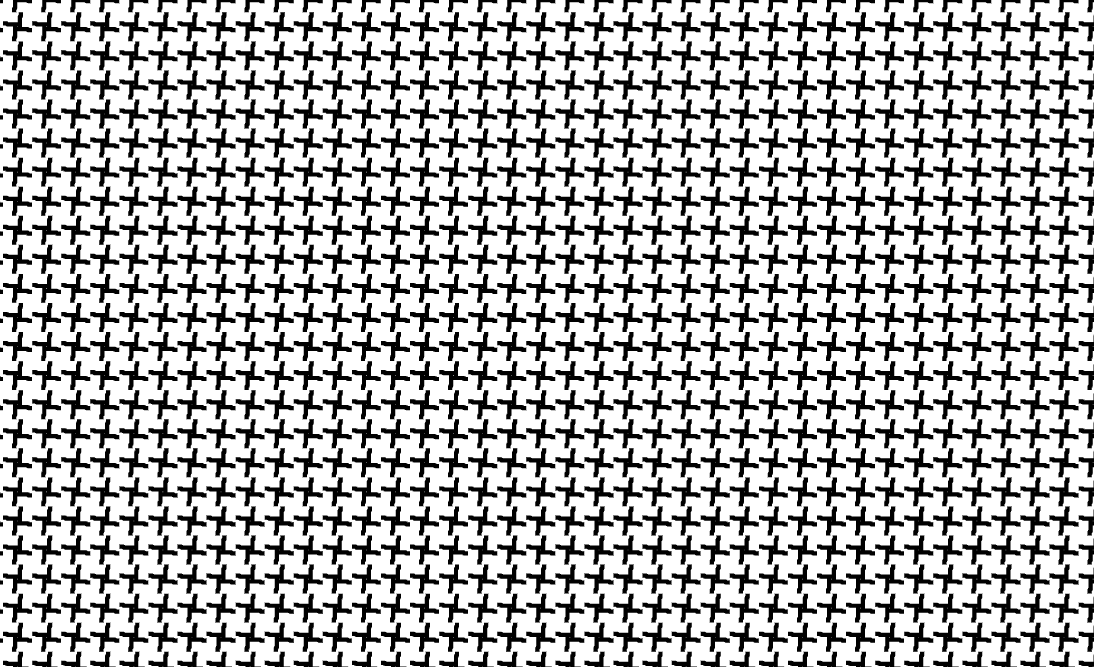

In [109]:
img = Image.open('images/C4pinwheel.png')
img = img.convert('L')
display(img)

In [110]:
i = 50
while i < 220:
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C4"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C4"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C4"))
    print(" ")
    i = i +20

n_samples with lens size  50 :  150
n_samples with lens size  50 :  150
n_samples with lens size  50 :  150
 
n_samples with lens size  70 :  300
n_samples with lens size  70 :  50
n_samples with lens size  70 :  300
 
n_samples with lens size  90 :  300
n_samples with lens size  90 :  150
n_samples with lens size  90 :  200
 
n_samples with lens size  110 :  150
n_samples with lens size  110 :  300
n_samples with lens size  110 :  100
 
n_samples with lens size  130 :  100
n_samples with lens size  130 :  400
n_samples with lens size  130 :  50
 
n_samples with lens size  150 :  150
n_samples with lens size  150 :  400
n_samples with lens size  150 :  250
 
n_samples with lens size  170 :  150
n_samples with lens size  170 :  250
n_samples with lens size  170 :  50
 
n_samples with lens size  190 :  100
n_samples with lens size  190 :  100
n_samples with lens size  190 :  100
 
n_samples with lens size  210 :  250
n_samples with lens size  210 :  100
n_samples with lens size  210 :  6

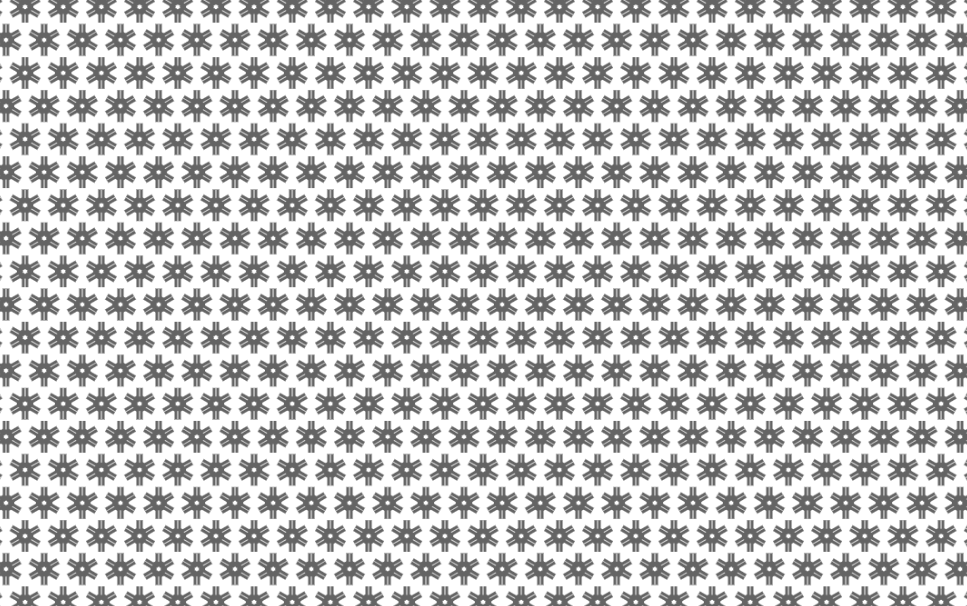

In [111]:
img = Image.open('images/C6 star.png')
img = img.convert('L')
display(img)

In [112]:
i = 50
while i < 260:
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C6"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C6"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C6"))
    print(" ")
    i = i +20

n_samples with lens size  50 :  200
n_samples with lens size  50 :  100
n_samples with lens size  50 :  300
 
n_samples with lens size  70 :  150
n_samples with lens size  70 :  100
n_samples with lens size  70 :  250
 
n_samples with lens size  90 :  300
n_samples with lens size  90 :  50
n_samples with lens size  90 :  200
 
n_samples with lens size  110 :  50
n_samples with lens size  110 :  100
n_samples with lens size  110 :  50
 
n_samples with lens size  130 :  450
n_samples with lens size  130 :  300
n_samples with lens size  130 :  150
 
n_samples with lens size  150 :  300
n_samples with lens size  150 :  200
n_samples with lens size  150 :  250
 
n_samples with lens size  170 :  150
n_samples with lens size  170 :  150
n_samples with lens size  170 :  300
 
n_samples with lens size  190 :  350
n_samples with lens size  190 :  150
n_samples with lens size  190 :  150
 
n_samples with lens size  210 :  200
n_samples with lens size  210 :  100
n_samples with lens size  210 :  2

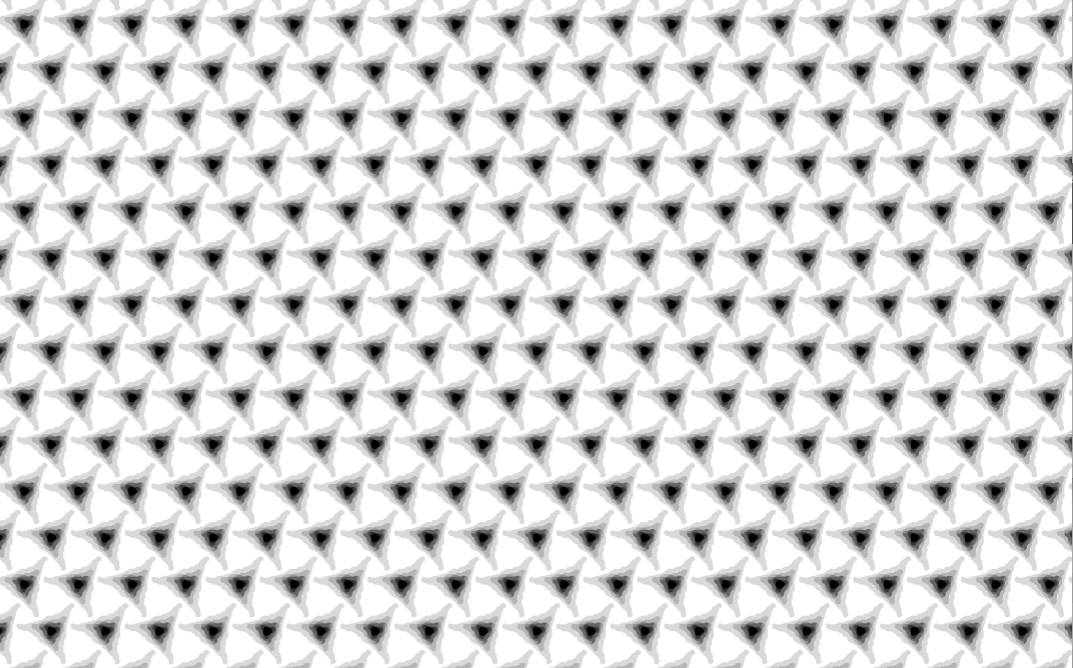

In [113]:
img = Image.open('images/C3gradient.png')
img = img.convert('L')
display(img)

In [114]:
i = 50
while i < 220:
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C3"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C3"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C3"))
    print(" ")
    i = i +20

n_samples with lens size  50 :  150
n_samples with lens size  50 :  250
n_samples with lens size  50 :  100
 
n_samples with lens size  70 :  250
n_samples with lens size  70 :  150
n_samples with lens size  70 :  200
 
n_samples with lens size  90 :  150
n_samples with lens size  90 :  100
n_samples with lens size  90 :  150
 
n_samples with lens size  110 :  250
n_samples with lens size  110 :  250
n_samples with lens size  110 :  300
 
n_samples with lens size  130 :  350
n_samples with lens size  130 :  100
n_samples with lens size  130 :  250
 
n_samples with lens size  150 :  200
n_samples with lens size  150 :  200
n_samples with lens size  150 :  100
 
n_samples with lens size  170 :  200
n_samples with lens size  170 :  50
n_samples with lens size  170 :  100
 
n_samples with lens size  190 :  200
n_samples with lens size  190 :  200
n_samples with lens size  190 :  100
 
n_samples with lens size  210 :  350
n_samples with lens size  210 :  150
n_samples with lens size  210 : 

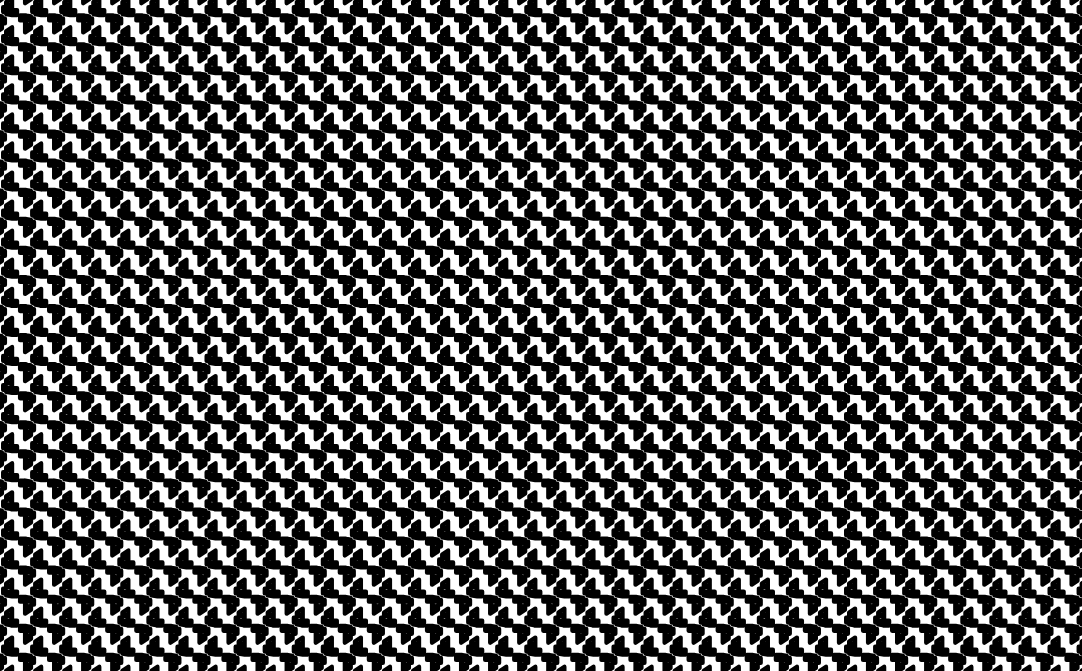

In [115]:
img = Image.open('images/C2bow.png')
img = img.convert('L')
display(img)

In [116]:
i = 50
while i < 220:
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C2"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C2"))
    print("n_samples with lens size ", i, ": ", find_density(img, i, "C2"))
    print(" ")
    i = i +20

n_samples with lens size  50 :  100
n_samples with lens size  50 :  50
n_samples with lens size  50 :  150
 
n_samples with lens size  70 :  150
n_samples with lens size  70 :  250
n_samples with lens size  70 :  200
 
n_samples with lens size  90 :  50
n_samples with lens size  90 :  200
n_samples with lens size  90 :  150
 
n_samples with lens size  110 :  250
n_samples with lens size  110 :  100
n_samples with lens size  110 :  50
 
n_samples with lens size  130 :  250
n_samples with lens size  130 :  350
n_samples with lens size  130 :  100
 
n_samples with lens size  150 :  250
n_samples with lens size  150 :  100
n_samples with lens size  150 :  200
 
n_samples with lens size  170 :  250
n_samples with lens size  170 :  100
n_samples with lens size  170 :  100
 
n_samples with lens size  190 :  200
n_samples with lens size  190 :  150
n_samples with lens size  190 :  250
 
n_samples with lens size  210 :  200
n_samples with lens size  210 :  50
n_samples with lens size  210 :  10

Overall, it appears that the lens size does not have an effect on the number of samples needed. This makes sense given the translational symmetry of the image. Consider that n points randomly sampled over several fundamental domains is effectively the same as all of those points being taken from one fundamental domain, since each fundamental domain is "layered" on top of eachother. Generally around 300 samples is sufficient, but since the sampling is random, sometimes it happens that none of those points are close enough to a center of rotation. 